In [1]:
#from google.colab import userdata
#import os

#os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
#os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
#!kaggle competitions download -c playground-series-s5e10
#! unzip "playground-series-s5e10.zip"

#!pip install catboost
#!pip install optuna

  0% 0.00/7.76M [00:00<?, ?B/s]
100% 7.76M/7.76M [00:00<00:00, 884MB/s]
Archive:  playground-series-s5e10.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import optuna
import copy



In [4]:
df_risk_train = pd.read_csv('train.csv')
df_risk_test = pd.read_csv('test.csv')
df1 = df_risk_train.copy()
df2 = df_risk_test.copy()

In [5]:
display(df1.head())
display(df2.head())

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [6]:
display(df1.shape)
display(df2.shape)

(517754, 14)

(172585, 13)

In [7]:
display(df1.info())
display(df2.info())

# No null seen in both train and test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


None

In [8]:
display(df1.describe())
display(df2.describe())

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


,id,num_lanes,curvature,speed_limit,num_reported_accidents
count,172585.000000,172585.000000,172585.000000,172585.000000,172585.000000
mean,604046.000000,2.494046,0.487263,46.102761,1.186059
std,49821.142441,1.119148,0.272343,15.787077,0.897161
min,517754.000000,1.000000,0.000000,25.000000,0.000000
25%,560900.000000,1.000000,0.260000,35.000000,1.000000
50%,604046.000000,2.000000,0.510000,45.000000,1.000000
75%,647192.000000,3.000000,0.710000,60.000000,2.000000
max,690338.000000,4.000000,1.000000,70.000000,7.000000


In [9]:
print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0


EDA

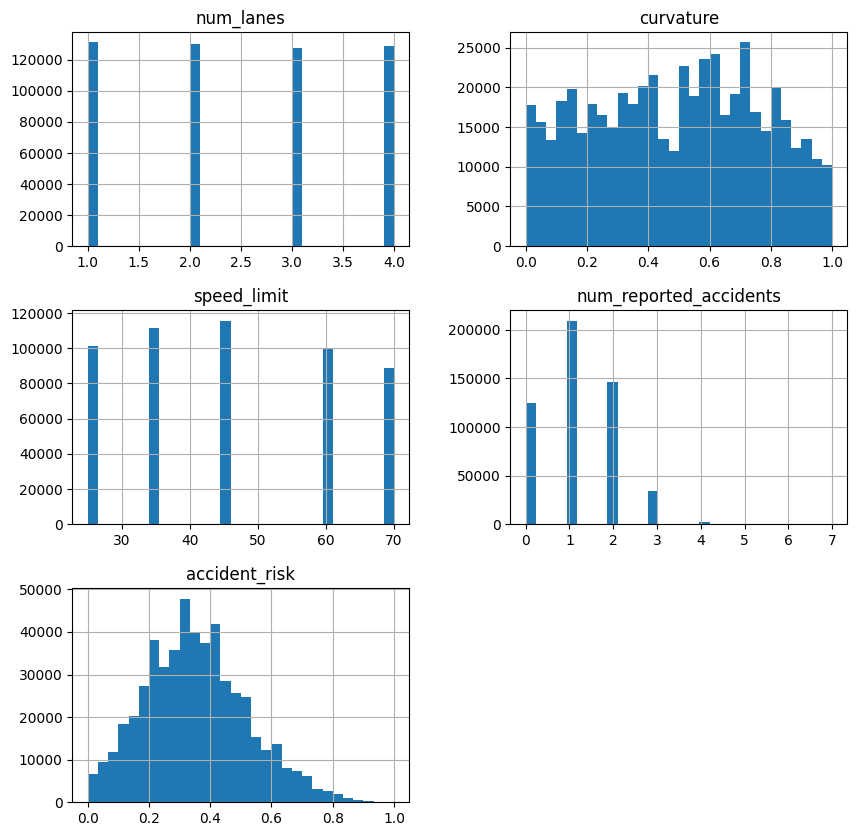

In [10]:
num_columns = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents','accident_risk']
df1[num_columns].hist(bins = 30, figsize = (10, 10))
plt.show()

# balanced distribution among num_lanes
# uniform distribution among curvature with no notable unlevel spikes
# speed limit clusters at a specific values, (25, 35, 45, 60, 70ish), uniform spread reflects a designation thru different road types
# num_reported_accidents heavily right skewed having 1 has the highest number of accidents, might tell us that road are safe
# accident risk slightly right skewed

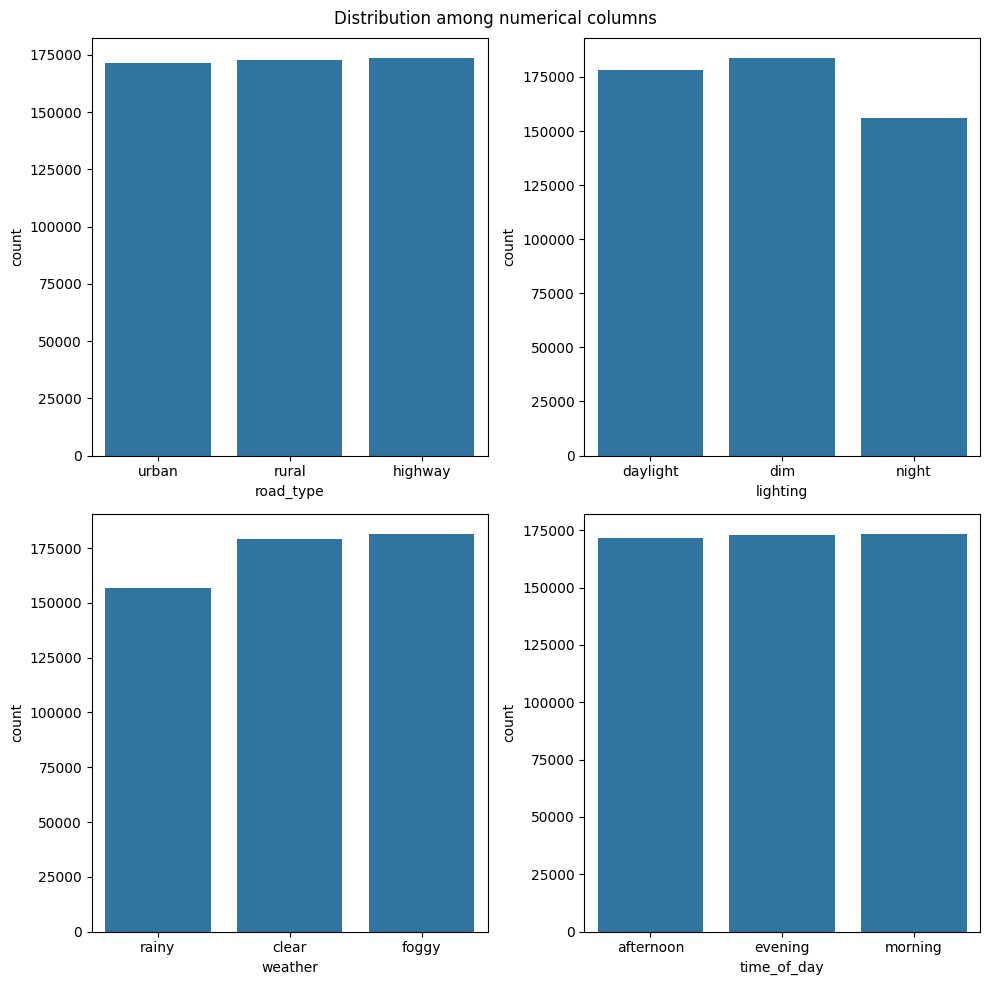

In [11]:
col_objects = ['road_type', 'lighting', 'weather', 'time_of_day']

fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for i, cols in enumerate(col_objects):
    sns.countplot(x = cols, data = df1, ax = axes[i])

plt.suptitle('Distribution among numerical columns')
plt.tight_layout()
plt.show()

# balanced distribution among road_type and time of day
# data collected is somewhat underrepresented
# balanced distribution between clear and foggy, rainy days however is underrepresented

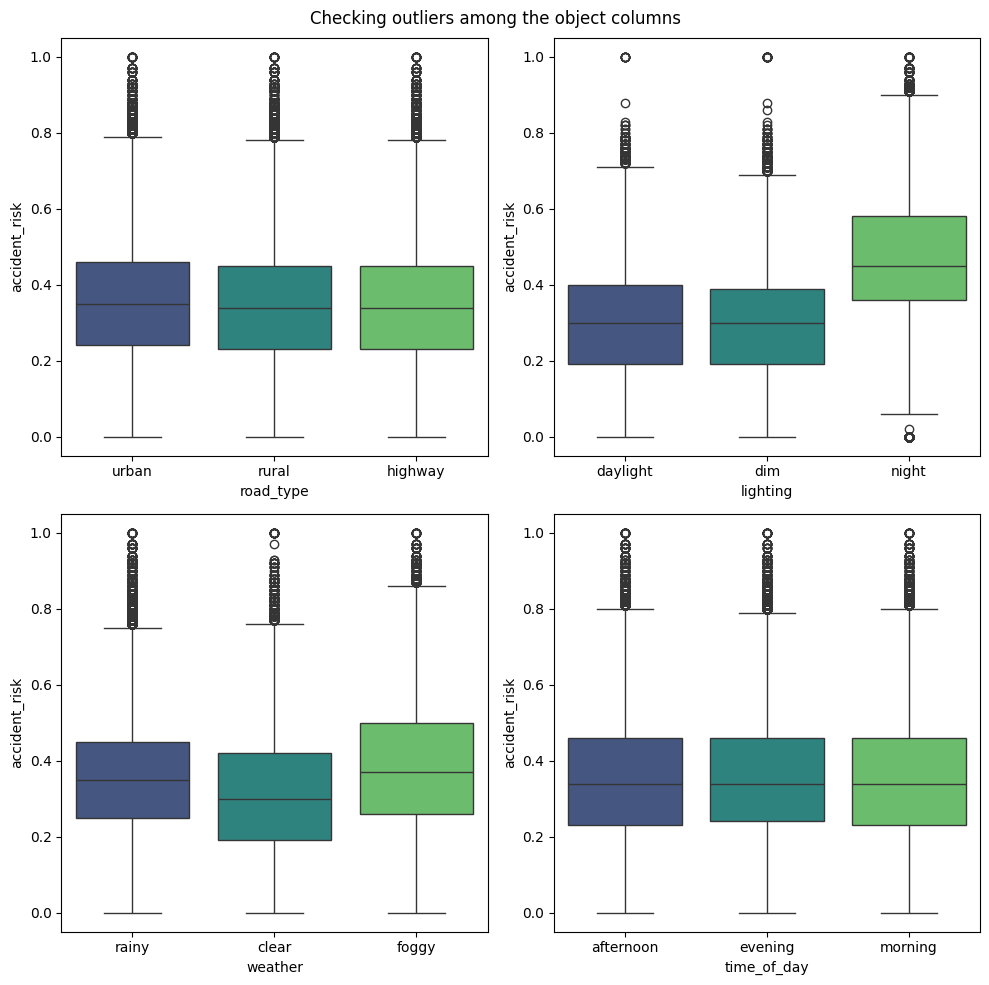

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for i, cols in enumerate(col_objects):
    sns.boxplot(data=df1,
                x=cols,
                y='accident_risk',
                ax = axes[i],
                hue = cols,
                palette= 'viridis',
                legend = False)

plt.suptitle('Checking outliers among the object columns')
plt.tight_layout()
plt.show()

# all three road types show nearly identical accident risk distributions might not be a strong indicator
# night driving carries notably elevated accident risk compared to daylight or dim conditions
# there is differene among the weathers but not a dominant influence
# time of day has little impact on accident risk, unlike lighting conditions which showed clear differences
# outliers reach a 1.0 max for all features

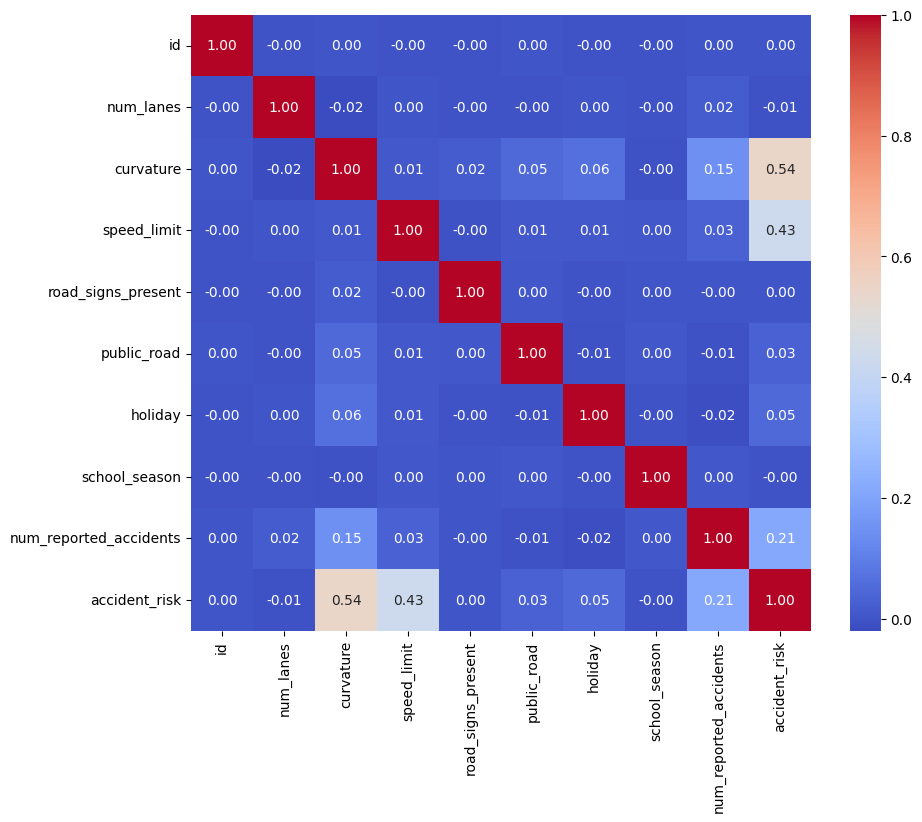

In [13]:
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# roads with sharper curves have significantly higher accident risk
# higher speed limits associate with higher accident risk
# past accidents moderately predict future risk
# no to little correlation observed in road_signs_present, school_season thus will be dropped

In [14]:
def object_columns(df1, df2):
    obj_cols_df1  = df1.select_dtypes(include= 'object').columns.tolist()
    obj_cols_df2  = df2.select_dtypes(include= 'object').columns.tolist()
    return obj_cols_df1, obj_cols_df2

obj_cols_df1, obj_cols_df2 = object_columns(df1, df2)

print(obj_cols_df1)
print(obj_cols_df2)

['road_type', 'lighting', 'weather', 'time_of_day']
['road_type', 'lighting', 'weather', 'time_of_day']


In [15]:
for col1, col2 in zip(obj_cols_df1, obj_cols_df2):
    print("DF1 value counts:")
    print(df1[col1].value_counts())
    print("DF2 value counts:")
    print(df2[col2].value_counts())

DF1 value counts:
road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64
DF2 value counts:
road_type
highway    58080
rural      57409
urban      57096
Name: count, dtype: int64
DF1 value counts:
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64
DF2 value counts:
lighting
dim         61143
daylight    59397
night       52045
Name: count, dtype: int64
DF1 value counts:
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64
DF2 value counts:
weather
foggy    60236
clear    59982
rainy    52367
Name: count, dtype: int64
DF1 value counts:
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64
DF2 value counts:
time_of_day
morning      57747
evening      57629
afternoon    57209
Name: count, dtype: int64


In [16]:
road_type_map = {'urban': 0, 'rural': 1, 'highway': 2}
lighting_map  = {'daylight': 0, 'dim': 1, 'night': 2}
weather_map   = {'clear': 0, 'rainy': 1, 'foggy': 2}
time_of_day   = {'morning': 0, 'evening': 1, 'afternoon': 2}


for col1, col2 in zip(obj_cols_df1, obj_cols_df2):
    if col1 == 'road_type' and col2 == 'road_type':
        df1[col1]= df1[col1].map(road_type_map)
        df2[col2] = df2[col2].map(road_type_map)
    elif col1 == 'lighting' and col2 == 'lighting':
        df1[col1]= df1[col1].map(lighting_map)
        df2[col2] = df2[col2].map(lighting_map)
    elif col1 == 'weather' and col2 == 'weather':
        df1[col1]= df1[col1].map(weather_map)
        df2[col2] = df2[col2].map(weather_map)
    elif col1 == 'time_of_day' and col2 == 'time_of_day':
        df1[col1]= df1[col1].map(time_of_day)
        df2[col2] = df2[col2].map(time_of_day)


In [17]:
def bool_cols (df1, df2):
    bool_cols_df1 = df1.select_dtypes(include= 'boolean').columns.tolist()
    bool_cols_df2 = df2.select_dtypes(include= 'boolean').columns.tolist()
    return bool_cols_df1, bool_cols_df2

bool_cols_df1, bool_cols_df2 = bool_cols (df1, df2)

In [18]:
for col in bool_cols_df1:
    df1[col] = df1[col].astype(int)

for col in bool_cols_df2:
    df2[col] = df2[col].astype(int)

In [19]:
# since curvature and speed limits are main predictors, lets derive insight from them
# heuristic were assign to give weight in determining risks

df1['curvature_speed_interaction'] = df1['curvature'] * df1['speed_limit']
df2['curvature_speed_interaction'] = df2['curvature'] * df2['speed_limit']

df1['road_complexity'] = 0.6*df1['curvature'] + 0.4*(df1['speed_limit']/df1['speed_limit'].max())
df2['road_complexity'] = 0.6*df2['curvature'] + 0.4*(df2['speed_limit']/df2['speed_limit'].max())

df1['environment_risk'] = df1['lighting'] + df1['weather']
df2['environment_risk'] = df2['lighting'] + df2['weather']


In [20]:
feature_cols = [
    'curvature', 'speed_limit', 'num_lanes',
    'curvature_speed_interaction', 'road_complexity',
    'lighting', 'weather', 'environment_risk',
    'road_type', 'time_of_day',
    'public_road', 'road_signs_present', 'holiday'
]

X = df1[feature_cols]
y = df1['accident_risk']

X_train, X_val, y_train, y_val, = train_test_split(X, y, test_size= 0.2, random_state= 2, shuffle= True)

In [21]:
models = {
    'Random Forest':{
        'model': RandomForestRegressor(random_state=2),
        'params':{
            'max_depth': [None, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2],
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 0.8]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=2, n_jobs=-1),
        'params': {
            'n_estimators': [200, 500],
            'learning_rate': [0.01, 0.03, 0.05],
            'num_leaves': [31, 63, 127],
            'max_depth': [-1, 8, 12],
            'min_child_samples': [10, 30, 60],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0.0, 0.1, 1.0],
            'reg_lambda': [0.0, 0.1, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_seed=2, verbose=0),
        'params': {
            'iterations': [500, 1000],
            'learning_rate': [0.01, 0.03, 0.05],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [1, 3, 7],
            'bagging_temperature': [0.0, 0.2, 0.5],
            'random_strength': [0.5, 1, 2]
        }
    }
}


In [22]:
results = {}
all_models = {}

N_TRIALS = 40
RANDOM_STATE = 42
SAMPLER = optuna.samplers.TPESampler(seed=RANDOM_STATE)
PRUNER = optuna.pruners.HyperbandPruner()

for name, config in models.items():

    model_template = config['model']
    param_grid = config['params']

    # Define Optuna objective
    def objective(trial):
        params = {}
        for p_name, p_values in param_grid.items():
            params[p_name] = trial.suggest_categorical(p_name, p_values)

        # Copy model and set params
        model = copy.deepcopy(model_template)
        model.set_params(**params)

        # Fit model (handle models with eval_set support)
        if 'LGBM' in name or 'XGB' in name:
            # set eval_metric as a parameter (works across xgboost versions)
            try:
                model.set_params(eval_metric='rmse')
            except Exception:
                pass
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=100,
                verbose=False
            )
        elif 'CatBoost' in name:
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                early_stopping_rounds=100,
                verbose=False
            )
        else:
            model.fit(X_train, y_train)

        # Predict and evaluate on validation
        preds_val = model.predict(X_val)

        # compute RMSE
        rmse = root_mean_squared_error(y_val, preds_val)
        return rmse

    # Create and run Optuna study
    study = optuna.create_study(direction='minimize', sampler=SAMPLER, pruner=PRUNER)
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

    best_params = study.best_trial.params

    # Refit best model on full training data
    best_model = copy.deepcopy(model_template)
    best_model.set_params(**best_params)

    if 'LGBM' in name or 'XGB' in name:
        try:
            best_model.set_params(eval_metric='rmse')
        except Exception:
            pass
        best_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=100,
            verbose=False
        )
    elif 'CatBoost' in name:
        best_model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=100,
            verbose=False
        )
    else:
        best_model.fit(X_train, y_train)

    all_models[name] = best_model

    # Predictions
    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)

    results[name] = {
        'best_model': best_model,
        'best_params': best_params,
        'Train MAE': mean_absolute_error(y_train, train_pred),
        'Test MAE': mean_absolute_error(y_val, val_pred),
        'Train R2': r2_score(y_train, train_pred),
        'Test R2': r2_score(y_val, val_pred),
        'Train RMSE': root_mean_squared_error(y_train, train_pred),
        'Test RMSE': root_mean_squared_error(y_val, val_pred)
    }

best_model_name = max(results.keys(), key=lambda x: results[x]['Test R2'])
best_model = results[best_model_name]['best_model']


[I 2025-10-13 07:05:11,399] A new study created in memory with name: no-name-af054085-3246-4346-b4ae-80413f6a973b


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-13 07:05:48,886] Trial 0 finished with value: 0.06173167675620958 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 100, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.06173167675620958.
[I 2025-10-13 07:11:14,267] Trial 1 finished with value: 0.0641480784932383 and parameters: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'n_estimators': 200, 'max_features': 0.8}. Best is trial 0 with value: 0.06173167675620958.
[I 2025-10-13 07:12:21,179] Trial 2 finished with value: 0.0619492820036181 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'n_estimators': 50, 'max_features': 0.8}. Best is trial 0 with value: 0.06173167675620958.
[I 2025-10-13 07:13:14,287] Trial 3 finished with value: 0.06146428209368204 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.06146428209368

[I 2025-10-13 08:52:38,023] A new study created in memory with name: no-name-d7f3f820-c7da-4621-a517-d529fdfe6561


  0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 13
[LightGBM] [Info] Start training from score 0.352439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-10-13 08:52:50,908] Trial 0 finished with value: 0.0610973264461693 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.0610973264461693.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015421 seconds.
You can set `f

[I 2025-10-13 09:03:30,406] A new study created in memory with name: no-name-03e2450b-6713-4028-b87f-29582b65702a


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-13 09:03:57,692] Trial 0 finished with value: 0.061720836931808326 and parameters: {'iterations': 500, 'learning_rate': 0.03, 'depth': 4, 'l2_leaf_reg': 3, 'bagging_temperature': 0.0, 'random_strength': 1}. Best is trial 0 with value: 0.061720836931808326.
[I 2025-10-13 09:04:55,107] Trial 1 finished with value: 0.06139286148686897 and parameters: {'iterations': 1000, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 1, 'bagging_temperature': 0.5, 'random_strength': 0.5}. Best is trial 1 with value: 0.06139286148686897.
[I 2025-10-13 09:06:21,030] Trial 2 finished with value: 0.06115235324851426 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 8, 'l2_leaf_reg': 1, 'bagging_temperature': 0.5, 'random_strength': 0.5}. Best is trial 2 with value: 0.06115235324851426.
[I 2025-10-13 09:06:48,857] Trial 3 finished with value: 0.061559803517016974 and parameters: {'iterations': 500, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 3, 'bagging_temperature': 0.2,

In [24]:
summary_data = []

for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Test R2': result['Test R2'],
        'Test RMSE': result['Test RMSE'],
        'Overfit Gap': result['Train R2'] - result['Test R2']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test R2', ascending = False)
summary_df = summary_df.round(4)
display(summary_df)

,Model,Test R2,Test RMSE,Overfit Gap
1,LightGBM,0.8655,0.0611,0.0020
2,CatBoost,0.8653,0.0611,0.0026
0,Random Forest,0.8652,0.0611,0.0013


In [39]:
X_test_final = df2[feature_cols]
preds = best_model.predict(X_test_final)

submission = pd.DataFrame({
    'id': df2['id'],
    'accident_risk': preds
})

submission.to_csv('submission2.csv', index=False,float_format='%.3f')


In [29]:
residuals = y_val - val_pred

residual_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': val_pred,
    'Residual': residuals
})
residual_df.head()


,Actual,Predicted,Residual
194138,0.52,0.401627,0.118373
367264,0.49,0.499116,-0.009116
408141,0.29,0.335474,-0.045474
166982,0.60,0.599815,0.000185
495696,0.42,0.388494,0.031506


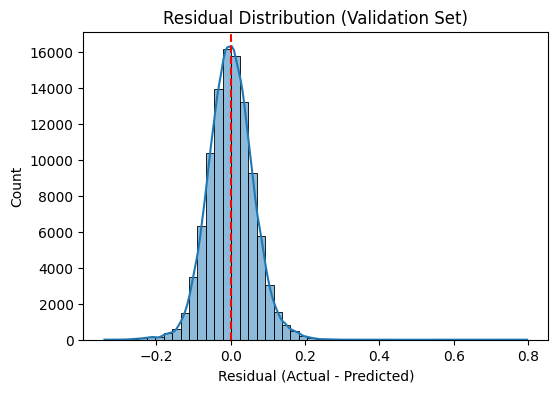

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(residual_df['Residual'], bins=50, kde=True)
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Centered tightly at 0 — no overall bias (model doesn’t systematically over- or underpredict).
# Symmetric and bell-shaped → residuals are roughly normal, which is great.
# Slight right tail (0.4–0.8) = a few high-risk roads where model slightly underpredicts (common in real-world risk problems).

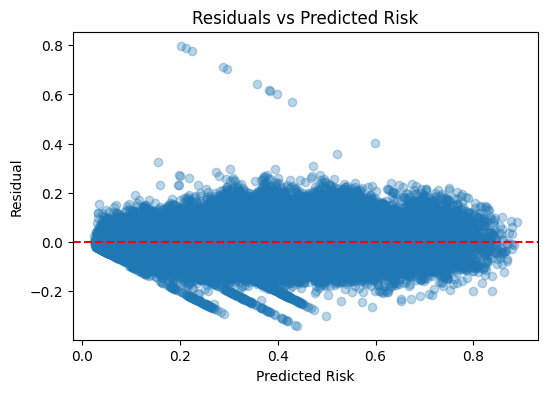

In [31]:
plt.figure(figsize=(6,4))
plt.scatter(residual_df['Predicted'], residual_df['Residual'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Risk')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Risk')
plt.show()

# The cloud is randomly scattered around 0 → no visible pattern.

# No U-shape or funnel → residuals have homoscedasticity (constant variance).

# A few outliers with residuals up to +0.6–0.8 at high risk values — means model slightly underestimates some extreme-risk roads

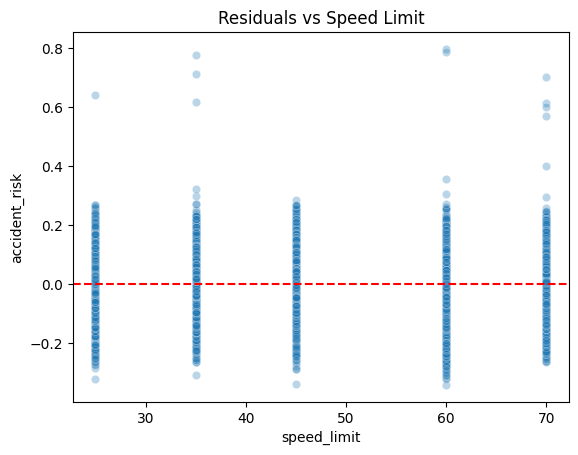

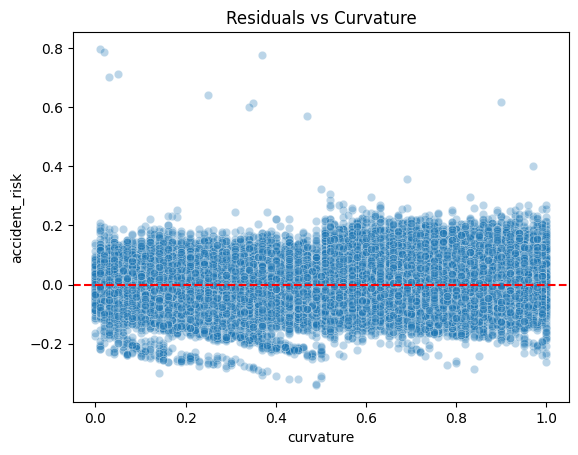

In [32]:
sns.scatterplot(x=X_val['speed_limit'], y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Speed Limit")
plt.show()

sns.scatterplot(x=X_val['curvature'], y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Curvature")
plt.show()

# Flat residuals at each speed limit bucket (25, 35, 45, 60, 70) — no trend.
# Most residuals clustered near 0 — consistent performance across speeds.
# A few high positive residuals (underpredictions) at 60–70 mph → model sometimes misses accidents on high-speed roads.

# Uniform spread across curvature 0–1.
# No slope or pattern — residuals are random.
# Slight vertical striping → due to discretization in curvature or sampling density (not a problem).
